In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
from warnings import filterwarnings
import matplotlib.pyplot as plt
filterwarnings('ignore')

In [2]:
genomics = pd.read_csv('C:\\Users\\nilav\\NCI Cell Lines\\nci_genomics.csv', index_col = 0)
genomics.head(2)

,Cell names,WASH7P,FAM138F,LOC729737,RPL23AP21,CICP7,CICP3,LOC101060494,LINC00115,LINC01128,...,MAFIP,LOC283788,KIR3DS1,LOC100507412,KIR2DS5,LOC100288966,KIR2DS1,MGC70870,HLA-DRB4,HLA-DRB3
0,BR:MCF7,0.499,1.863,1.137,0.095,-0.356,-0.368,0.120,-0.253,-0.449,...,0.949,-0.028,-0.169,0.935,0.168,0.892,0.090,0.474,-0.201,-0.761
1,BR:MDA-MB-231,-0.386,0.786,0.931,-0.086,-0.508,0.744,-0.364,-0.510,-0.078,...,-1.306,-0.861,-0.169,0.246,-0.207,0.701,-0.293,-0.145,0.185,-0.528


In [3]:
gemc = pd.read_csv('C:\\Users\\nilav\\NCI Cell Lines\\Cisplatin_NCI.csv')
gemc.head(2)

,Cell names,Cisplatin,cells
0,BR:MDA-MB-231,1.411583,MDAMB231
1,BR:HS 578T,1.572590,HS578T


In [4]:
working_data = genomics.merge(gemc, on='Cell names')
working_data.shape

(59, 25043)

In [5]:
gemc.shape

(59, 3)

In [6]:
working_data.head(2)

,Cell names,WASH7P,FAM138F,LOC729737,RPL23AP21,CICP7,CICP3,LOC101060494,LINC00115,LINC01128,...,KIR3DS1,LOC100507412,KIR2DS5,LOC100288966,KIR2DS1,MGC70870,HLA-DRB4,HLA-DRB3,Cisplatin,cells
0,BR:MDA-MB-231,-0.386,0.786,0.931,-0.086,-0.508,0.744,-0.364,-0.510,-0.078,...,-0.169,0.246,-0.207,0.701,-0.293,-0.145,0.185,-0.528,1.411583,MDAMB231
1,BR:HS 578T,-0.585,0.021,-0.801,-0.795,-0.499,0.720,-1.207,0.098,0.823,...,-0.169,-0.303,-0.268,0.669,-0.246,-1.024,-0.512,-0.172,1.572590,HS578T


In [7]:
target = working_data.pop('Cisplatin')
X = working_data.select_dtypes('float64')

In [8]:
X.head(2)

,WASH7P,FAM138F,LOC729737,RPL23AP21,CICP7,CICP3,LOC101060494,LINC00115,LINC01128,TUBB8P11,...,MAFIP,LOC283788,KIR3DS1,LOC100507412,KIR2DS5,LOC100288966,KIR2DS1,MGC70870,HLA-DRB4,HLA-DRB3
0,-0.386,0.786,0.931,-0.086,-0.508,0.744,-0.364,-0.510,-0.078,-0.045,...,-1.306,-0.861,-0.169,0.246,-0.207,0.701,-0.293,-0.145,0.185,-0.528
1,-0.585,0.021,-0.801,-0.795,-0.499,0.720,-1.207,0.098,0.823,1.923,...,-0.920,-0.619,-0.169,-0.303,-0.268,0.669,-0.246,-1.024,-0.512,-0.172


In [9]:
mean = target.mean()
y = []
for i in list(target):
    if i>mean:
        y.append('NR')
    else:
        y.append('R')
y = pd.Series(y)

<AxesSubplot:ylabel='Density'>

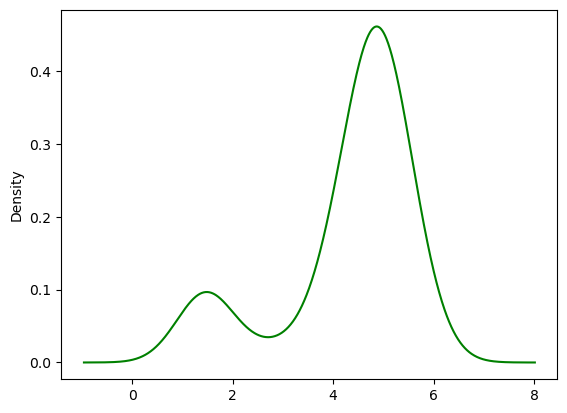

In [10]:
target.plot.density(color = 'green')

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    42
1    17
dtype: int64

In [12]:
scaler = StandardScaler()
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)

In [13]:
X.head(2)

,WASH7P,FAM138F,LOC729737,RPL23AP21,CICP7,CICP3,LOC101060494,LINC00115,LINC01128,TUBB8P11,...,MAFIP,LOC283788,KIR3DS1,LOC100507412,KIR2DS5,LOC100288966,KIR2DS1,MGC70870,HLA-DRB4,HLA-DRB3
0,-0.378306,0.843224,0.969494,-0.090111,-0.514618,0.745022,-0.365166,-0.569089,-0.096179,-0.058416,...,-1.409597,-0.947768,-0.173007,0.281863,-0.204345,0.828610,-0.294187,-0.144175,0.200366,-0.548336
1,-0.577735,0.054258,-0.797510,-0.847027,-0.505608,0.720787,-1.215538,0.085113,0.959963,2.199502,...,-0.987777,-0.681527,-0.173007,-0.309179,-0.266444,0.791586,-0.246095,-1.128775,-0.564902,-0.187441


In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X,y = smote.fit_resample(X,y)

y.value_counts()

1    42
0    42
dtype: int64

In [15]:
X.shape, y.shape

((84, 25040), (84,))

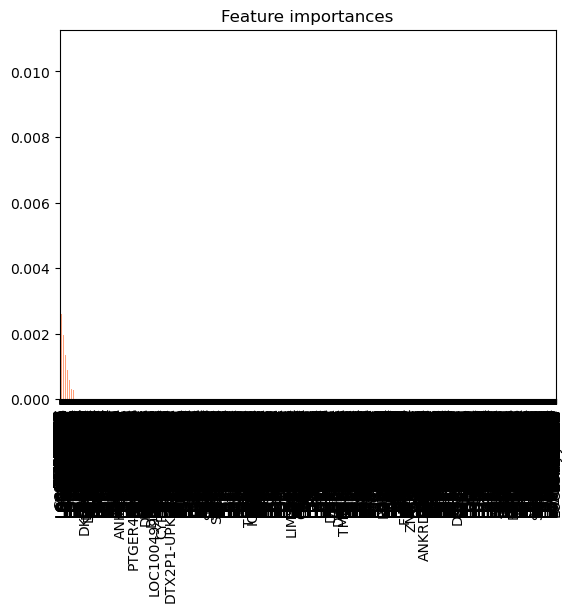

In [16]:
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

model = RandomForestClassifier(class_weight = 'balanced', n_estimators = 150, random_state = 43)
model.fit(X, y)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="lightsalmon", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [17]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report

sfm = SelectFromModel(model, threshold = 0.002)
sfm.fit(X,y)

X = pd.DataFrame(data = sfm.transform(X), columns = X.columns[sfm.get_support(1)])
indices = X.index.values
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.33, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
model.fit(X_train, y_train)
prediction = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

print(f'Accuracy on training data: {accuracy_score(y_train, model.predict(X_train))}')
print(f'Accuracy on testing data: {accuracy_score(y_test, model.predict(X_test))}')
print(classification_report(y_test, y_pred))

Accuracy on training data: 1.0
Accuracy on testing data: 0.9285714285714286
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.92      0.92      0.92        12

    accuracy                           0.93        28
   macro avg       0.93      0.93      0.93        28
weighted avg       0.93      0.93      0.93        28



Text(50.722222222222214, 0.5, 'True Labels')

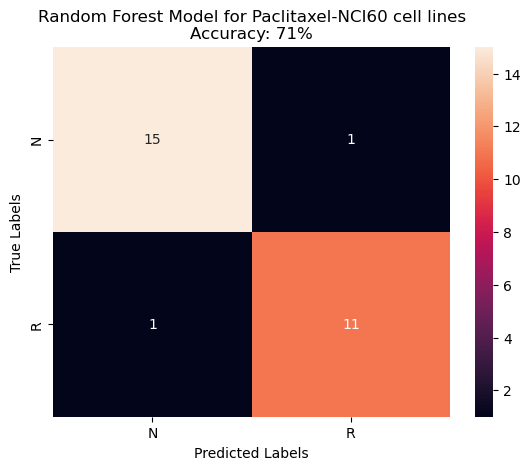

In [18]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels = ['N', 'R'], yticklabels = ['N', 'R'])
ax.set_title('Random Forest Model for Paclitaxel-NCI60 cell lines\nAccuracy: 71%')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

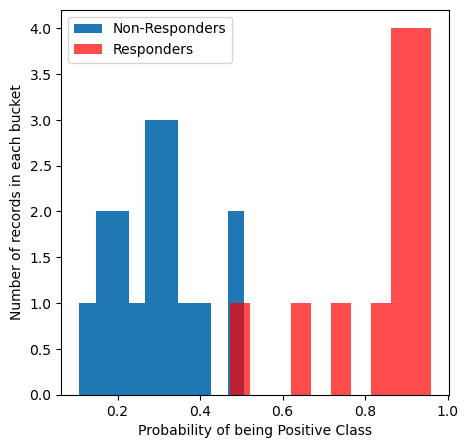

In [19]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders')
plt.hist(prediction[y_test==1], label='Responders', alpha=0.7, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [20]:
responders = prediction[y_test == 1]
count = 0
for i in responders: 
    if i > max(prediction[y_test == 0]):
        count+=1
count, count/len(responders)

(11, 0.9166666666666666)

In [21]:
max(prediction[y_test == 0])

0.5066666666666667

In [22]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction

df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [23]:
df1_main = df1.iloc[:49, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(3, 190)

In [41]:
df1_main

,CALML6,RPS16P1,HSPB7,TMEM200B,SLC6A9,AGBL4,LEXM,NFIA,CFL1P3,ANKRD13C,...,GRPR,PPEF1,PORCN,GSPT2,CPXCR1,ZNF280C,PCDH11Y,TTTY2,MGC70870,test_proba
0,0.083822,-0.179159,-0.364687,2.701874,0.893671,0.443635,-0.018797,-0.081910,0.517860,1.844479,...,-0.251607,-0.424153,0.607886,-0.912342,-0.032005,-0.500089,-0.491981,0.960341,-0.144175,0.873333
1,0.197012,-0.585057,2.586721,2.104103,2.567008,-1.410958,0.920017,-1.101667,2.261378,0.909135,...,1.240368,-0.465351,0.230658,-0.734952,-1.240070,-1.815878,-0.269283,2.580741,-1.128775,0.946667
2,0.816446,-0.644188,-0.246556,-0.614758,2.742917,-0.261845,-1.466912,-1.358843,0.648734,1.021332,...,0.440696,-0.463124,-0.692067,-1.371267,-0.478281,0.618976,-0.449288,1.846644,-0.143055,0.626667


In [24]:
model2 = SVC(kernel = 'linear', C=1, gamma='auto', probability=True)
model2.fit(X_train, y_train)
prediction2 = model2.predict_proba(X_test)[:, 1]
y_pred = model2.predict(X_test)
print(f'Accuracy on training data: {accuracy_score(y_train, model2.predict(X_train))}')
print(f'Accuracy on testing data: {accuracy_score(y_test, model2.predict(X_test))}')
print(classification_report(y_test, y_pred))

Accuracy on training data: 1.0
Accuracy on testing data: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        12

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



Text(50.722222222222214, 0.5, 'True labels')

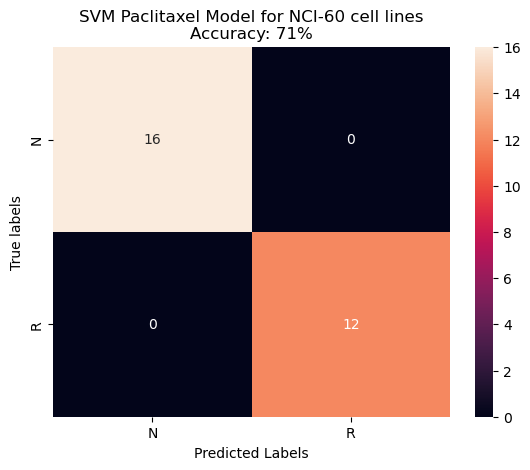

In [25]:
fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels = ['N', 'R'], yticklabels = ['N', 'R'])
ax.set_title('SVM Paclitaxel Model for NCI-60 cell lines\nAccuracy: 71%')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True labels')

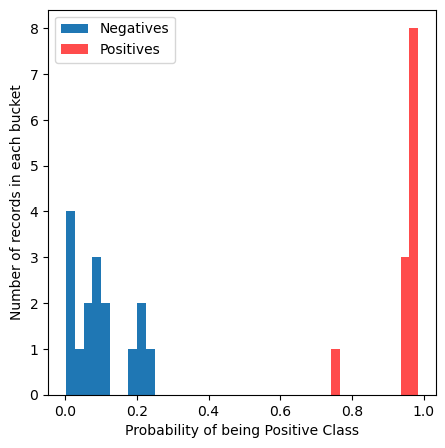

In [26]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives')
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.7, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [27]:
resp_svm = prediction2[y_test == 1]
count = 0
for i in resp_svm:
    if i > max(prediction2[y_test == 0]):
        count+=1
count, count/len(resp_svm)

(12, 1.0)

In [28]:
max(prediction2[y_test == 0])

0.2501010327273236

In [29]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2

df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [30]:
df2_main = df2.iloc[:49, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,CALML6,RPS16P1,HSPB7,TMEM200B,SLC6A9,AGBL4,LEXM,NFIA,CFL1P3,ANKRD13C,...,GRPR,PPEF1,PORCN,GSPT2,CPXCR1,ZNF280C,PCDH11Y,TTTY2,MGC70870,test_proba
0,0.083822,-0.179159,-0.364687,2.701874,0.893671,0.443635,-0.018797,-0.081910,0.517860,1.844479,...,-0.251607,-0.424153,0.607886,-0.912342,-0.032005,-0.500089,-0.491981,0.960341,-0.144175,0.975381
1,0.197012,-0.585057,2.586721,2.104103,2.567008,-1.410958,0.920017,-1.101667,2.261378,0.909135,...,1.240368,-0.465351,0.230658,-0.734952,-1.240070,-1.815878,-0.269283,2.580741,-1.128775,0.953136
2,0.816446,-0.644188,-0.246556,-0.614758,2.742917,-0.261845,-1.466912,-1.358843,0.648734,1.021332,...,0.440696,-0.463124,-0.692067,-1.371267,-0.478281,0.618976,-0.449288,1.846644,-0.143055,0.973826
22,-2.049368,0.245781,-0.305157,-1.394750,-1.335979,-1.035703,-1.976212,-1.333125,0.672026,1.324596,...,-0.523384,-0.485393,0.166870,-1.031365,-0.779398,1.626243,0.066495,-1.477283,-0.255068,0.740772


In [31]:
model3 = XGBClassifier()
model3.fit(X_train, y_train)
prediction3 = model3.predict_proba(X_test)[:, 1]
y_pred = model3.predict(X_test)
print(f'Accuracy on training data: {accuracy_score(y_train, model3.predict(X_train))}')
print(f'Accuracy on testing data: {accuracy_score(y_test, model3.predict(X_test))}')
print(classification_report(y_test, y_pred))

Accuracy on training data: 1.0
Accuracy on testing data: 0.9285714285714286
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.92      0.92      0.92        12

    accuracy                           0.93        28
   macro avg       0.93      0.93      0.93        28
weighted avg       0.93      0.93      0.93        28



Text(50.722222222222214, 0.5, 'True Labels')

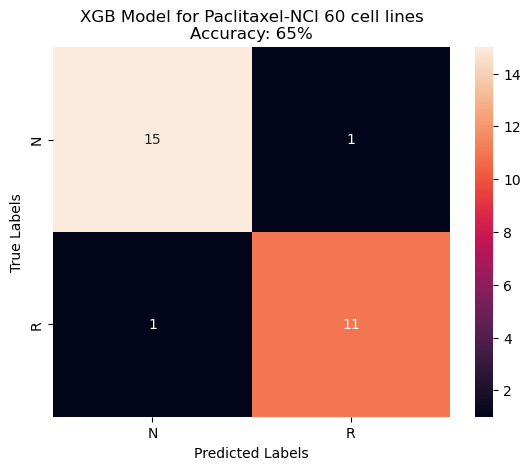

In [32]:
fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, xticklabels = ['N', 'R'], yticklabels = ['N', 'R'])
ax.set_title('XGB Model for Paclitaxel-NCI 60 cell lines\nAccuracy: 65%')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

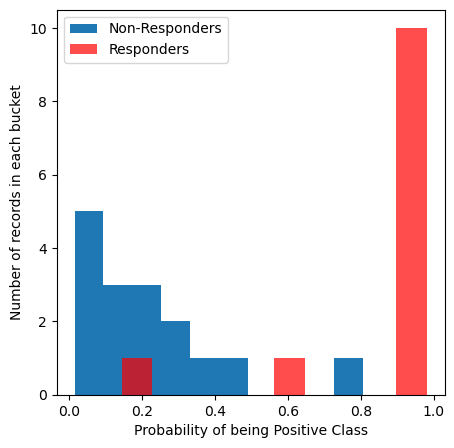

In [33]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders')
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [34]:
resp_xg = prediction3[y_test == 1]
count = 0
for i in resp_xg:
    if i > max(prediction3[y_test == 0]):
        count += 1
count, count/len(resp_xg)

(10, 0.8333333333333334)

In [35]:
max(prediction3[y_test == 0])

0.80541

In [36]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3

df3 = pd.concat([X_train, df_xg], sort=False).sort_index()

In [37]:
df3_main = df3.iloc[:49, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,CALML6,RPS16P1,HSPB7,TMEM200B,SLC6A9,AGBL4,LEXM,NFIA,CFL1P3,ANKRD13C,...,GRPR,PPEF1,PORCN,GSPT2,CPXCR1,ZNF280C,PCDH11Y,TTTY2,MGC70870,test_proba
0,0.083822,-0.179159,-0.364687,2.701874,0.893671,0.443635,-0.018797,-0.081910,0.517860,1.844479,...,-0.251607,-0.424153,0.607886,-0.912342,-0.032005,-0.500089,-0.491981,0.960341,-0.144175,0.981371
1,0.197012,-0.585057,2.586721,2.104103,2.567008,-1.410958,0.920017,-1.101667,2.261378,0.909135,...,1.240368,-0.465351,0.230658,-0.734952,-1.240070,-1.815878,-0.269283,2.580741,-1.128775,0.966029


In [40]:
df3_main

,CALML6,RPS16P1,HSPB7,TMEM200B,SLC6A9,AGBL4,LEXM,NFIA,CFL1P3,ANKRD13C,...,GRPR,PPEF1,PORCN,GSPT2,CPXCR1,ZNF280C,PCDH11Y,TTTY2,MGC70870,test_proba
0,0.083822,-0.179159,-0.364687,2.701874,0.893671,0.443635,-0.018797,-0.081910,0.517860,1.844479,...,-0.251607,-0.424153,0.607886,-0.912342,-0.032005,-0.500089,-0.491981,0.960341,-0.144175,0.981371
1,0.197012,-0.585057,2.586721,2.104103,2.567008,-1.410958,0.920017,-1.101667,2.261378,0.909135,...,1.240368,-0.465351,0.230658,-0.734952,-1.240070,-1.815878,-0.269283,2.580741,-1.128775,0.966029


In [38]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 26, 1: 30}

In [39]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 16, 1: 12}

In [42]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))
cl = set(common_list)
with open('master_list_genomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')